# Overview

Important notes:
* This is a early prototype of potential functions of `ragali`. There might be errors in the code and naming of functions and variables might change later.
* Current implementations are focuse mostly on CMLs because plotting lines is not as easy as plotting points and because getting radar values along CMLs is harder then getting radar values at a certain point.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sys

In [3]:
import sys
sys.path.append('..')

import ragali as rgl

## Load small OpenMRG dataset for radar and CML

* CML data should comply almost completely with OPENSENSE data format conventions (see results of `format_check` below).
* Radar data format has to be decided, but should probably follow what the `xradar` package does.
* Gauge data format also not decided, but should follow PWS format conventions (use `id` instead of `station_id`?).
* Please note that the gauge data is from a different period (because I use the one that Max Graf parsed to NetCDF for his method intercomparison).

In [4]:
ds_cmls = xr.open_dataset('data/openMRG_example.nc')

# Calculate tl and interpolate short gaps
ds_cmls['tl'] = ds_cmls.tsl - ds_cmls.rsl
ds_cmls['tl'] = ds_cmls.tl.interpolate_na(dim='time')
# Very quick way to create attenuation data that I need for plotting below (no time to do CML data processing here)
ds_cmls['A'] = ds_cmls.tl - ds_cmls.tl.rolling(time=60, center=True).median()

ds_cmls

<xarray.Dataset>
Dimensions:       (sublink_id: 2, cml_id: 364, time: 1500)
Coordinates:
  * sublink_id    (sublink_id) object 'sublink_1' 'sublink_2'
  * cml_id        (cml_id) int64 10001 10002 10003 10004 ... 10362 10363 10364
    site_0_lat    (cml_id) float64 ...
    site_0_lon    (cml_id) float64 ...
    site_1_lat    (cml_id) float64 ...
    site_1_lon    (cml_id) float64 ...
    frequency     (sublink_id, cml_id) float64 ...
    polarization  (sublink_id, cml_id) object ...
    length        (cml_id) float64 ...
  * time          (time) datetime64[ns] 2015-08-27 ... 2015-08-28T00:59:00
Data variables:
    tsl           (time, sublink_id, cml_id) float32 ...
    rsl           (time, sublink_id, cml_id) float32 ...
    tl            (time, sublink_id, cml_id) float32 47.0 41.0 ... 55.8 49.5
    A             (time, sublink_id, cml_id) float32 nan nan nan ... nan nan nan
Attributes: (12/14)
    title:                 Transformed and resampled OpenMRG-CML
    version:               1.1
    source:                Swedish Meteorological and Hydrological Institute ...
    contact:               hydro.fou@smhi.se, jafet.andersson@smhi.se, erlend...
    license:               https://creativecommons.org/licenses/by-sa/4.0
    doi:                   https://doi.org/10.5281/zenodo.6673750
    ...                    ...
    institution:           NA
    date:                  NA
    history:               NA
    naming convention:     NA
    license restrictions:  NA
    reference:             NA

In [5]:
ds_radar = xr.open_dataset('data/openMRG_example_rad.nc')
ds_radar

<xarray.Dataset>
Dimensions:   (time: 19, x: 37, y: 48)
Coordinates:
  * time      (time) datetime64[ns] 2015-08-27T01:00:00 ... 2015-08-27T02:30:00
  * x         (x) float64 -1.542e+05 -1.522e+05 ... -8.42e+04 -8.22e+04
  * y         (y) float64 -3.413e+06 -3.415e+06 ... -3.505e+06 -3.507e+06
Data variables:
    crs       int32 ...
    lat       (y, x) float32 ...
    lon       (y, x) float32 ...
    rainfall  (time, y, x) float64 ...
Attributes:
    source:       Swedish Meteorological and Hydrological Institute (SMHI), H...
    contact:      hydro.fou@smhi.se, remco.vandebeek@smhi.se
    title:        OpenMRG-Radar
    license:      https://creativecommons.org/licenses/by-sa/4.0
    version:      1.1
    doi:          https://doi.org/10.5281/zenodo.6673750
    proj_string:  +proj=stere +lat_ts=60 +ellps=bessel +lon_0=14 +lat_0=90
    comment:      Created by Remco van de Beek, Victor Näslund and Johan Thur...

In [6]:
ds_city_gauges = xr.open_dataset('data/openMRG_city_gauges_20150827.nc')
ds_city_gauges

<xarray.Dataset>
Dimensions:          (time: 1440, station_id: 10)
Coordinates:
  * station_id       (station_id) object 'Jarn' 'Torp' ... 'Lbom' 'Askim'
  * time             (time) datetime64[ns] 2015-08-27 ... 2015-08-27T23:59:00
    lon              (station_id) float64 ...
    lat              (station_id) float64 ...
    location         (station_id) object ...
    type             (station_id) object ...
    quantization     (station_id) float64 ...
Data variables:
    rainfall_amount  (time, station_id) float64 ...

## Check data format

This format checker dynamically get the OPENSENSE format specifications from our respective github repo https://github.com/OpenSenseAction/OS_data_format_conventions and then checks all entries that are required.

Open points:
* currently only implemented for CML data, needs to update for gauges (and radar, too?).
* what to do with "recommended" variables, maybe issue a warning if they are missing, or make checking optional?
* how to version the data format (can be done for the repo with format definition, but how to link to specific versions here)?

### Check CML data format

In [7]:
rgl.format_check.check_required_cml_metadata(ds_cmls)

Checking required variables...
 time
  OK
 cml_id
  OK
 sublink_id
  OK
 site_0_lat
  OK
 site_0_lon
  OK
 site_1_lat
  OK
 site_1_lon
  OK
 frequency
  dims of variable 'frequency' are ('sublink_id', 'cml_id') but have to be ('cml_id', ' sublink_id')
 tsl
  dims of variable 'tsl' are ('time', 'sublink_id', 'cml_id') but have to be ('cml_id', ' sublink_id', ' time')
 rsl
  dims of variable 'rsl' are ('time', 'sublink_id', 'cml_id') but have to be ('cml_id', ' sublink_id', ' time')

3 errors found


In [8]:
# now remove important variable and run check again

rgl.format_check.check_required_cml_metadata(ds_cmls.drop('site_0_lat'))

Checking required variables...
 time
  OK
 cml_id
  OK
 sublink_id
  OK
 site_0_lat
  Required variable 'site_0_lat' is missing
 site_0_lon
  OK
 site_1_lat
  OK
 site_1_lon
  OK
 frequency
  dims of variable 'frequency' are ('sublink_id', 'cml_id') but have to be ('cml_id', ' sublink_id')
 tsl
  dims of variable 'tsl' are ('time', 'sublink_id', 'cml_id') but have to be ('cml_id', ' sublink_id', ' time')
 rsl
  dims of variable 'rsl' are ('time', 'sublink_id', 'cml_id') but have to be ('cml_id', ' sublink_id', ' time')

4 errors found


### Check radar data format

In [9]:
# TODO... and maybe rely on `xradar`?

### Check gauge data format

In [10]:
# TODO...

## Plot data on a map

### Plot CML paths on map

It is easy to plot gridded data and to plot points with a colormap (using scatter plots). But there is no standard way to plot lines with a colormap. There are some example implementation, but none that I like. It should also be possible to quickly adjust the colors so that one can skip through different time stamps.

Below is an example implementation that seems robust and flexible. Note that the actual code is just 50 lines long.

Open points:
* allow to plot lines, gauges and grid on same map and use joint time slider (using highst temporal resolution dataset and then select closese time stamp in other datasets)
* be more flexible with WMS tiles in `cartopy`.
* plot onto dynamic web map (use `folium` which leverages `leaflet.js`)
* would be great to be able to click on a line to get `cml_id` which could then be used to subset the dataset when looking for suspicious CMLs


In [11]:
%matplotlib inline

Plot mean of rolling standard deviatoin of `tl` for each CML

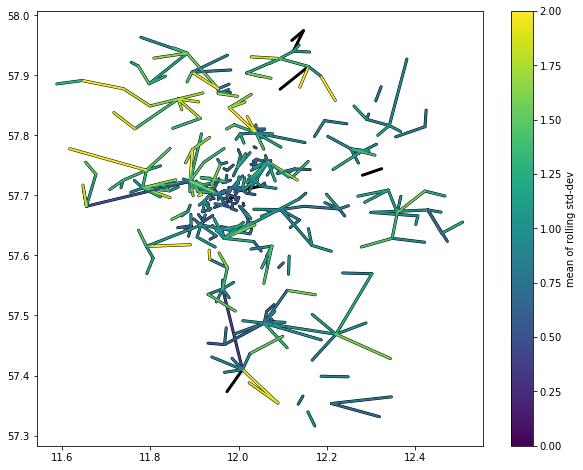

In [12]:
fig, ax = plt.subplots(figsize=(10, 8));
lines = rgl.plot_map.scatter_line(
    da=ds_cmls.isel(sublink_id=0).tl.rolling(time=60).std().mean(dim='time'),
    ax=ax,
    vmin=0,
    vmax=2,
);
plt.colorbar(lines, label='mean of rolling std-dev');

Now we add a time slider. We have to switch to interactive backend of `matplotlib`.

We plot `A` for each CML and can skip through the time stamps with the slider.

In [13]:
%matplotlib widget

interactive(children=(SelectionSlider(description='t', options=(numpy.datetime64('2015-08-27T00:00:00.00000000…

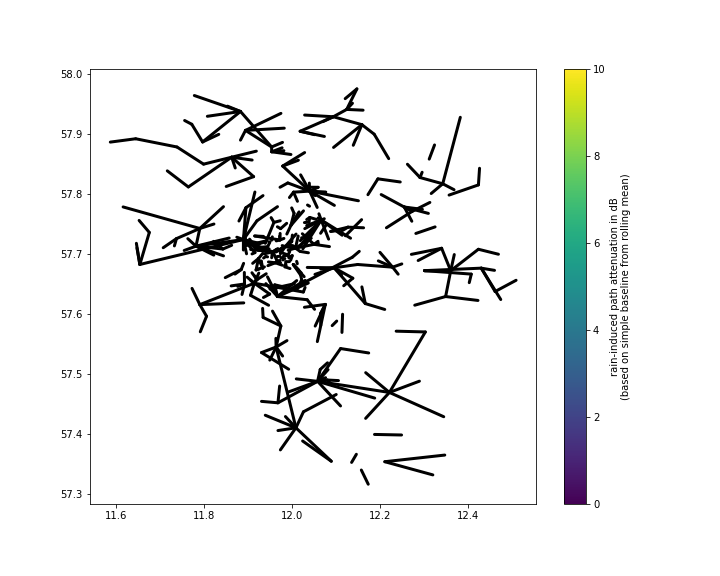

In [14]:
fig, ax = plt.subplots(figsize=(10, 8));
lines = rgl.plot_map.scatter_line(
    da=ds_cmls.isel(sublink_id=0).A,
    add_time_slider=True,
    ax=ax,
    vmin=0,
    vmax=10,
);
plt.colorbar(lines, label='rain-induced path attenuation in dB\n(based on simple baseline from rolling mean)');

In [15]:
#import cartopy
import cartopy.crs as ccrs
#import cartopy.io.img_tiles as cimgt

interactive(children=(SelectionSlider(description='t', options=(numpy.datetime64('2015-08-27T00:00:00.00000000…

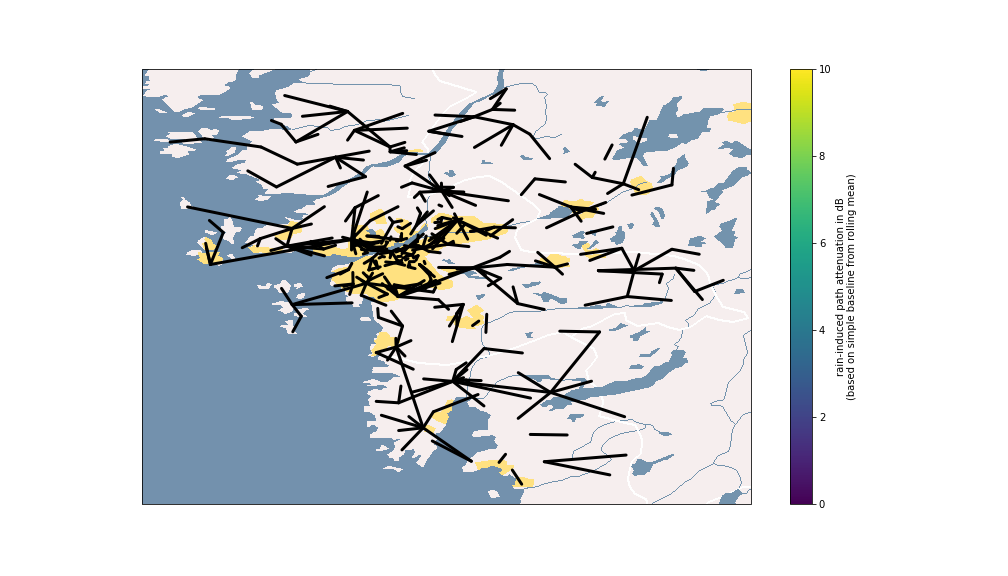

In [16]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.add_wms(
    wms='http://vmap0.tiles.osgeo.org/wms/vmap0',
    layers=['basic'],
    wms_kwargs={'zoom_level': 10},
)

lines = rgl.plot_map.scatter_line(
    da=ds_cmls.isel(sublink_id=0).A,
    add_time_slider=True,
    ax=ax,
    vmin=0,
    vmax=10,
)

plt.colorbar(lines, label='rain-induced path attenuation in dB\n(based on simple baseline from rolling mean)');

### Plot radar, gauge and line data onto one map

In [17]:
# TODO...




# Find neighbouring sensors or grid intersections

### Find pixel of grid for point data

In [18]:
# TODO ... can use wradlib functions or a variation of them




### Get grid data from intersections with lines (CML paths)

In [19]:
# TODO: Needs more thought...
# Either there is an error in my code or it has to do with the fact
# that I have to transpose the grids here when using grid_point_location='lower_left'
# because otherwise I get an error "y values must be ascending along axis 0".
# 
# For many CMLs the grid intersections are empty, even though the grid lon-lat 
# and the CML lon-lat seem to fit when viewed on a map...

intersect_weights = rgl.grid_intersection.calc_sparse_intersect_weights_for_several_cmls(
    ds_cmls=ds_cmls,
    x_grid=ds_radar.lon.values,
    y_grid=ds_radar.lat.values,
    #grid_point_location='lower_left',
    grid_point_location='center',
)

# Use grid intersection weights to calculate radar-CML path-averages
radar_along_cml = rgl.grid_intersection.get_grid_time_series_at_intersections(
    #grid_data=ds_radar.rainfall.transpose('time', 'x', 'y').values, # only needed if we have to transpose in the function above
    grid_data=ds_radar.rainfall.values,
    intersect_weights=intersect_weights,
)

# TODO: Add these coordinates already in the function to get the time series
radar_along_cml['time'] = ds_radar.time
radar_along_cml['site_0_lat'] = intersect_weights.site_0_lat
radar_along_cml['site_0_lon'] = intersect_weights.site_0_lon
radar_along_cml['site_1_lat'] = intersect_weights.site_1_lat
radar_along_cml['site_1_lon'] = intersect_weights.site_1_lon

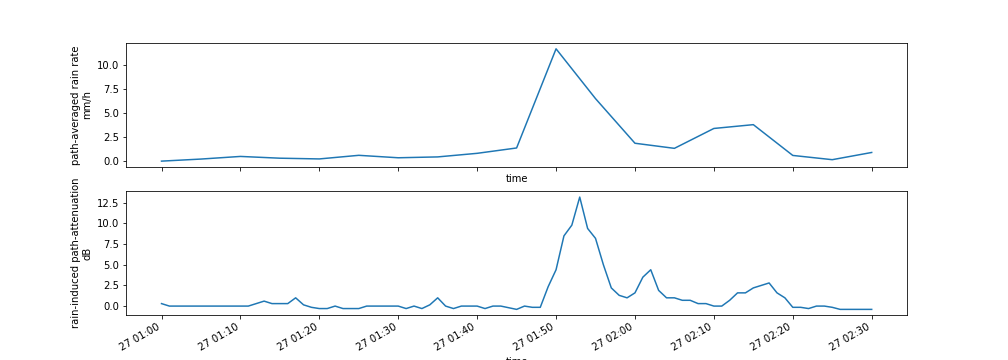

In [20]:
fig, axs = plt.subplots(2, 1, figsize=(14, 5), sharex=True)
i = 223
radar_along_cml.isel(cml_id=i).plot(ax=axs[0])
(ds_cmls
 .isel(cml_id=i, sublink_id=0)
 .sel(time=slice(radar_along_cml.time.min(), radar_along_cml.time.max()))
 .A.plot(zorder=-3, ax=axs[1])
)
axs[0].set_ylabel('path-averaged rain rate\nmm/h');
axs[1].set_ylabel('rain-induced path-attenuation\ndB');
axs[0].set_title('')
axs[1].set_title('');

We can quickly plot the `radar_along_cml` on the map

interactive(children=(SelectionSlider(description='t', options=(numpy.datetime64('2015-08-27T01:00:00.00000000…

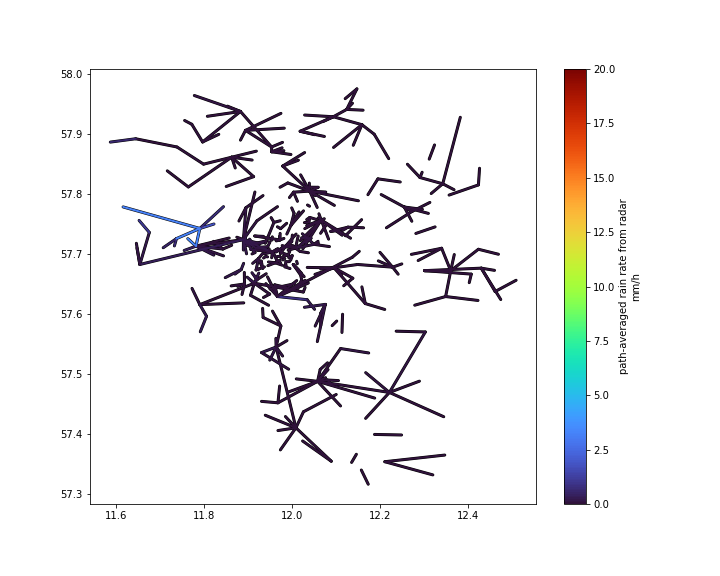

In [21]:
fig, ax = plt.subplots(figsize=(10, 8));
lines = rgl.plot_map.scatter_line(
    da=radar_along_cml,
    add_time_slider=True,
    ax=ax,
    vmin=0,
    vmax=20,
    cmap='turbo',
);
plt.colorbar(lines, label='path-averaged rain rate from radar\nmm/h');

### Find gauge close to CML path

In [22]:
# TODO 
# ...can be done with shapely
# ...or with brute-force approach using many points along CML path
# ...or with analytical solution?





## Validation

There is nothing here yet, but this is the content that would fit

### binary metrics for wet-dry

In [23]:
# TODO...
# 
# calculate some metrics
# define standard plots 

### QPE validation per sensors

In [24]:
# TODO...




### QPE validation of maps

In [25]:
# TODO...


